<h1> IBM Data Science Capstone Project</h1>
<h5> Author : Voranipit </h5>
This notebook  will mainly use for IBM course assignment

<h3> Introduction and Bussiness Problem </h3>

   <b>Problem </b> : <br>           Which bussiness will be recommended to run in Toronto neighborhood ,why it will profitable?<br>
,What is target customer group ? and how to do it efficienctly? <br>

<b>Which data do you need to solve the problem ?<br></b>
We need data set that contain category of venues in Toronto as much as possible.<br>

<b>Where is the data sources ?<br></b>
- Post code , neighborhood of each borough from wikipedia in order to specified which neighborhood is in Toronto Neighborhood.<br>
- FoursquareAPI in order to get venues in each neighborhood.<br>



<b>Which format of data set we need ?<br></b>
-Rows of each neighborhood in Toronto and the columns of Top 10 most common venues in each neighborhood(rows).<br>
-Rows of each neighborhood in Toronto and the columns of frequent of each venues to use to train model.<br>

<b>How data will use for solve the problem ?<br></b>
Once we know cluster of other venues we will find inside of the data that why in that cluster has that most common venues .<br>
when we know the reason we can use that reason to find out which bussiness will be profitable.<br>

<h3> Data  Preparation</h3>

<p style="font-size:14px"><b>Data Source :</b> 
I had scraped it form  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M . <br>
if you want to see how I scraping look at Scraping_Wikipedia.ipynb in the same repository . <br>
and I merge it with another dataframe if you want to see process look at Merge_Tables.ipynb in the same repository. <br>
In oder to this make notebook look clean ,I seperated them out.</p>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import  json
import requests
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium


In [2]:
df  = pd.read_csv('neighborhood_toronto.csv')
col =  df.columns
df.drop(col[0],axis= 1 , inplace = True)
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<p style="font-size:14px">Choose only rows that has borough  as Toronto. </p>

In [3]:
toronto  = df[df.Borough.str.contains(pat = 'Toronto')]
print(len(toronto))
toronto.head()

39


,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923


<p style="font-size:14px">Next we have to fetch venues nearby each neighboorhood from FoursquareAPI to create data set .</p>

In [4]:
#Four square API information
VERSION = '20180605' # Foursquare API version
CLIENT_ID = 'DMQGJMJTKSXWTUV1IOA0CAZSUNSFVVY5I3GSWJHJULZ1VWHU' 
CLIENT_SECRET = 'Z24OKJGAWBUZ1A5FCK30IUTGLQTJQROLYQ1OUBKRHBKX44SM'
ACCESS_TOKEN = 'FVDGJE2C23Q1V0AJ2YUW2R0HXRBJ0OIH2DZ1ZGR3CTLJLZ50'
LIMIT = 100 # A default Foursquare API limit value

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
  
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list]) # In short it mean items in venue_list
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )


The Beaches
The Danforth  East
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Enclave of M5E
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction 

In [7]:
print(toronto_venues.shape)
toronto_venues.head()

(1603, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth East,43.685347,-79.338106,The Path,43.683923,-79.335007,Park


In [8]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

#move neighborhood column to the first column
temp = ['Neighborhood']
print(type(temp))
temp2 = list(toronto_onehot.columns[:])
temp2.remove('Neighborhood')
fixed_columns = temp  + temp2
toronto_onehot = toronto_onehot[fixed_columns]
print(toronto_onehot.shape)
toronto_onehot.head()

<class 'list'>
(1603, 240)


,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<p style="font-size:14px">Next we have to grouped it by nieghborhood and calculate amount of each  categories per neighborhood by mean.</p>

In [9]:
neighborhood=  toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(neighborhood.shape)
neighborhood.head()

(39, 240)


,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017241,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.017241,0.051724,0.0,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.0,0.000000,0.000000,0.000000,0.0,0.017241,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0000,0.0,0.034483,0.0,0.0,0.0,0.000000,0.017241,0.051724,0.051724,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000,0.034483,0.0,0.0,0.0,0.017241,0.0,0.0

<p style="font-size:14px"> So now  we got the dataset as we expected for training model. </p>

<h3> Model Clustering </h3>

<b>Choosing Model :</b><br> 
<p style="font-size:14px">I had tried k -means and it has too many outlier so I choose to use DBSCAN instead.</p> <br>
<b>Tunning parameter :</b>
<p style="font-size:14px"> inorder to using DBSCAN  we have to find optimal epsilon value.<br>
by these step. (reference = https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) <br></b>
1.calculate nearest n points for each point (nearest neighbor).<br>
2.sorting and ploting the result.<br>
3. Choose the  point where the change is most pronounced as epsilon value.
</p>

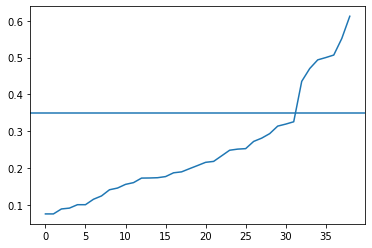

In [10]:
# Calculate the distance from each point to its closest neighbour using the NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors 
X =  neighborhood.drop('Neighborhood',1)
nn   =  NearestNeighbors(n_neighbors = 2)
results =  nn.fit(X)
distances, indices = results.kneighbors(X)
#sort and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(0.35)
plt.plot(distances)
#so now we got optimal value for epsilon that is 0.35

<p style="font-size:14px"> According to graph above we choose  epsilon  = 0.35<p>

In [11]:

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.35, min_samples=5).fit(X)
labels = db.labels_

unique ,count =  np.unique(labels,return_counts  =True)
print('Cluster : count')
for i,j in zip(unique,count):
    print(i ,':',j)


Cluster : count
-1 : 7
0 : 32


<p style="font-size:14px"> From the results above our data has only one cluster( label = 0 is cluster , label = -1 is outlier)</p>

<h3> Identify clusters </h3>

<p style="font-size:14px"> Next we have to explore data in  cluster ,so that we will adjust data format to see what's inside cluster.</p>

In [12]:


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [13]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
topten = pd.DataFrame(columns=columns)
topten['Neighborhood'] = neighborhood['Neighborhood']

for ind in np.arange(neighborhood.shape[0]):
    topten.iloc[ind, 1:] = return_most_common_venues(neighborhood.iloc[ind, :], num_top_venues)
topten['label'] =labels


In [14]:
cluster1 =  topten[topten['label']==0]
cluster1.reset_index(inplace =True,drop = True)
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,label
0,Berczy Park,Cocktail Bar,Coffee Shop,Bakery,Pharmacy,Beer Bar,Restaurant,Seafood Restaurant,Cheese Shop,Farmers Market,Pub,0
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Bakery,Italian Restaurant,Stadium,Furniture / Home Store,Nightclub,Office,Climbing Gym,0
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Airport,Rental Car Location,Coffee Shop,Sculpture Garden,Boat or Ferry,Bar,0
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Salad Place,Restaurant,Japanese Restaurant,Bubble Tea Shop,Comic Shop,0
4,Christie,Grocery Store,Café,Park,Baby Store,Candy Store,Italian Restaurant,Restaurant,Athletics & Sports,Coffee Shop,Nightclub,0
5,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Bubble Tea Shop,Fast Food Restaurant,Hotel,Mediterranean Restaurant,Men's Store,0
6,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Gym,Seafood Restaurant,Deli / Bodega,Bakery,Japanese Restaurant,Italian Restaurant,0
7,Davisville,Pizza Place,Dessert Shop,Sandwich Place,Italian Restaurant,Café,Gym,Sushi Restaurant,Coffee Shop,Thai Restaurant,Pharmacy,0
8,Davisville North,Breakfast Spot,Playground,Convenience Store,Sandwich Place,Gym / Fitness Center,Gym,Food & Drink Shop,Hotel,Park,Department Store,0
9,"Dufferin, Dovercourt Village",Bakery,Pharmacy,Brewery,Park,Bank,Music Venue,Supermarket,Café,Bar,Grocery Store,0


<p style="font-size:14px"> From data above we will see this cluster have something in common which is venues in these neighborhood have a lot of food and drink.
</p>

<h3> Seeking For oppotunity </h3>

<p style="font-size:14px"> <b>What we got from the data above ?</b> <br>
-there are a lot food venues in the neighborhood which maybe there are a lot of people (tourism) in the area.<br>
-the area is crowded with food venues so it is red ocean area for restuarant bussiness.<br>
<b>How we can take advantage of this information ? </b><br>
the answer is  making bussiness to bussiness (B2B) wholesale  such as ingredient wholesale.
</p>

<h3>How to do it  efficiently  ? </h3>

<p style="font-size:14px">  First we have to find out which ingredient we suppose to make profit from .

In [23]:
neighborhood['label'] = labels
sum_venues = neighborhood[neighborhood['label']==0]  
sum_venues.drop(['Neighborhood'],axis = 1,inplace =True)
overall = sum_venues.sum(axis = 0)
overall.sort_values(ascending =False,inplace =True)
overall =  pd.DataFrame(overall)
overall.columns = ['Frequency']
overall.head(15)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Frequency
Coffee Shop,2.388552
Café,1.710782
Restaurant,1.040286
Park,0.954142
Italian Restaurant,0.924607
Bakery,0.741535
Bar,0.703809
Sandwich Place,0.664338
Pizza Place,0.610235
Grocery Store,0.525943


<p style="font-size:16px"><b> Other reference :   </b><br>
 sometimes only source of information can not confirm that things go well while analizing it so I have to find other reference.<br>    
 the paragraph in this article https://www.toronto.ca/business-economy/invest-in-toronto/strong-economy/  say that <br>
    <br><i>        " Toronto is <b>competitive</b> in almost every other major business sector from technology and life sciences to green energy; from fashion and <br>design to <b>food and beverage</b>, from film and television production to music and digital media. Toronto’s rich industrial diversity drives growth, innovation and <br>cross-sectoral synergies and knowledge spillovers have spawned new leading-edge hybrid sectors including med-tech, green-tech and food-tech. "</i><br>
    <b> this paragraph is support that data we used is reasonable. </b><br>
   
</p>

<p style="font-size:16px"> <b> Analyzing information and seeking for oppotunity : </b><br>
    These food venues have some ingredient that they use in common which is <b>"Flour" </b><br>
    because there are a lot of <b> Bakery ,Pizza Place ,Sandwich Place and even coffee shop </b>they need some bakery which mean they are our customer's customer.<br>
According to  these food's shelf - life we can make repeatable profit ,<br>
and there are a lot of demand so  we don't need to depend too much on either one of category of venues.
 </p>

<b>Which neighborhood we should aim for prospect ?</b>

In [22]:
prospect = neighborhood[neighborhood['label']==0]
prospect.Neighborhood

0                                           Berczy Park
1          Brockton, Parkdale Village, Exhibition Place
2     CN Tower, King and Spadina, Railway Lands, Har...
3                                    Central Bay Street
4                                              Christie
5                                  Church and Wellesley
6                        Commerce Court, Victoria Hotel
7                                            Davisville
8                                      Davisville North
9                          Dufferin, Dovercourt Village
10                                       Enclave of M4L
11                                       Enclave of M5E
12               First Canadian Place, Underground city
14                             Garden District, Ryerson
15    Harbourfront East, Union Station, Toronto Islands
16                        High Park, The Junction South
17                       India Bazaar, The Beaches West
18            Kensington Market, Chinatown, Gran



<h3> Conclusion and actionable recommendation.<h3> 

<p style="font-size:16px"> According to data we use ,If you want to run bussiness in Toronto(in prospect list above).<br>
    I reccomend your bussiness should be flour wholesale  which is it can make repeatable profit and there are a lot of demand.<br> but if you don't like flour bussiness , I still recommend you to run ingredient wholesale bussiness or B2B bussiness instead of getting into the restuarant which is red ocean market now. </p>